# Train, Validation, Test Split and Dissection of Scans to Patchs.
1. Performs the train, validation and test split of the lung-segmented scans and their corresponding ground truth nodule-mask scans. The split is done by reading the SeriesInstanceUIDs of all scans and randomizing them into three categories at a 8:1:1 ratio. The randomization is done at the scan level rather than the image/slice level.

2. Dissect the 3D scans into 2D images.

**Authors**: Chen "Raphael" Liu and Nanyan "Rosalie" Zhu, *Columbia University*

**Date**: April 27, 2019

## Define environmental variables and paths.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from glob import glob as glob
import re
import random
import pydicom
from pydicom.data import get_testdata_files
import imageio
import pandas as pd
from math import ceil
%matplotlib inline
#import warnings
#warnings.filterwarnings('ignore')

## Summary of all the files we need.
**There are two datasets we worked with.**
1. LUNA16 dataset.
    - This is what we use to generate the inputs to the deep learning models.
2. LIDC-IDRI dataset.
    - This is the parent dataset of LUNA16 (everthing in LUNA16 came from LIDC).
    - We found the voxel-level annotations on this dataset given by radiologists (from which we generated the ground truth scans). Therefore some ground truth scans are not corresponding to anything in LUNA16 dataset.

**We have these files available, either gathered online or generated by our preprocessing steps.**
1. LUNA16 raw scans.
    - Type: *.mhd and *.raw.
    - Quantity: 888.
    - Content: unprocessed 3D CT lung scans from LUNA16 dataset.
    - Location: /home/raphael/Projects/DL-Lung_Nodule_LUNA16/Datasets/LUNA16_dataset/scans_all
2. Preprocessed scans.
    - Type: *.dcm.
    - Quantity: ongoing, should be 888 by completion.
    - Content: thresholded and contrast-enhanced 3D CT lung scans from LUNA16 dataset.
    - Location: /home/raphael/Projects/DL-Lung_Nodule_LUNA16/Solutions/LungAndNoduleMasks/3DLungMasks/Preprocessed
3. Lung-segmented scans.
    - Type: *.dcm
    - Quantity: ongoing, should be 888 by completion.
    - Content: lung-segmented 3D CT lung scans from LUNA16 dataset.
    - Location: /home/raphael/Projects/DL-Lung_Nodule_LUNA16/Solutions/LungAndNoduleMasks/3DLungMasks/Segmented
4. Ground truth scans.
    - Type: *.dcm
    - Quantity: 3544 (886 scans, each annotated by 4 radiologists). Note that the number of scans annotated is smaller than the total number of LIDC files and maybe smaller than the size of LUNA16 dataset of 888 because some patients may not have a nodule at all.
    - Content: binary voxel-level 3D masks representing whether or not each voxel belongs to a nodule, from the LIDC dataset.
    - Location: home/raphael/Projects/DL-Lung_Nodule_LUNA16/Solutions/LungAndNoduleMasks/3DNoduleMasks    

In [2]:
raw_scans_path = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Datasets/LUNA16_dataset/scans_all'
preprocessed_scans_path = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Solutions/LungAndNoduleMasks/3DLungMasks/Preprocessed'
lung_segmented_scans_path = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Solutions/LungAndNoduleMasks/3DLungMasks/Segmented'
ground_truth_scans_path = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Solutions/LungAndNoduleMasks/3DNoduleMasks'
modified_LUNA16_annotation_path = '/home/raphael/Projects/DL-Lung_Nodule_LUNA16/Datasets/LUNA_annotation/annotation_in_scan.csv'

## Read all SeriesInstanceUIDs and perform train, validation, test split.

In [3]:
# Read the file names of the LUNA16 raw scans. They will be in the form of 'directory/SeriesUID.dcm'.
raw_scans_filenames = glob(raw_scans_path + '/*.mhd')

# Construct a list of SeriesInstanceUIDs.
SeriesInstanceUIDs = []
for current_filename in raw_scans_filenames:
    current_SeriesInstanceUID_with_extension = re.split('/', current_filename)[-1]
    current_SeriesInstanceUID = current_SeriesInstanceUID_with_extension[0:-4]
    SeriesInstanceUIDs.append(current_SeriesInstanceUID)

# Check the length of the list. Should be 888.
len(SeriesInstanceUIDs)

888

In [4]:
# Set the random seed to make the randomization replicable.
random.seed(20190427)

# Perform train, validation and test split on these SeriesInstanceUIDs.
# Define the splitting ratio. Here we use 8:1:1.
train_sample_fraction = 0.8
validation_sample_fraction = 0.1

# First randomly sample indices for the train set.
index_pool_available = range(len(SeriesInstanceUIDs))
train_sample_size = round(len(SeriesInstanceUIDs)*train_sample_fraction)
train_indices = random.sample(index_pool_available, train_sample_size)

# Then randomly sample indices for the validation set.
index_pool_available = list(set(index_pool_available) - set(train_indices))
validation_sample_size = round(len(SeriesInstanceUIDs)*validation_sample_fraction)
validation_indices = random.sample(index_pool_available, validation_sample_size)

# The remaining indices are assigned to the test set.
test_indices = list(set(index_pool_available) - set(validation_indices))

In [5]:
# Check the size of each set.
len(train_indices), len(validation_indices), len(test_indices)

(710, 89, 89)

In [6]:
# Split the SeriesInstanceUIDs.
SeriesInstanceUIDs_train = [SeriesInstanceUIDs[index] for index in train_indices]
SeriesInstanceUIDs_validation = [SeriesInstanceUIDs[index] for index in validation_indices]
SeriesInstanceUIDs_test = [SeriesInstanceUIDs[index] for index in test_indices]

## Read our modified LUNA16 annotation spreadsheet (x, y, z, r).

In [7]:
# Read the resized annotation.csv (the coordinates are resized to match the dimensions of the preprocessing and lung-segmetation result)
modified_LUNA16_annotation = pd.read_csv(modified_LUNA16_annotation_path)
modified_LUNA16_annotation.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,29,136,140,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,261,100,211,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,240,169,160,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,96,183,266,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,122,163,252,18.545150


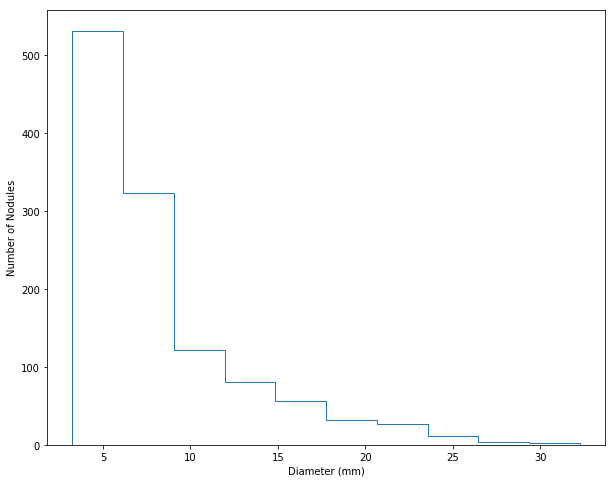

In [21]:
diameter = list(np.asarray((modified_LUNA16_annotation))[:,4])
fig = plt.figure(1)
plt.rcParams['figure.figsize'] = [10, 6]
ax = fig.add_subplot(111)
#ax.set_title('Histogram of LUNA16 Nodule Diameter')
plt.hist(diameter, histtype = 'step');
ax.set_xlabel('Diameter (mm)')
ax.set_ylabel('Number of Nodules')
plt.show()

## Clean up the LUNA16 annotation and create a dictionary of horizontal slices to use.
- We will only include horizontal slices that contain one and only one nodule.

In [9]:
clean_LUNA16_annotation = dict.fromkeys(list(np.array(modified_LUNA16_annotation.seriesuid)))
for SeriesInstanceUID in list(clean_LUNA16_annotation.keys()):
    # Extract a small dataframe that only contains the current scan.
    nodules_in_this_scan = modified_LUNA16_annotation[modified_LUNA16_annotation['seriesuid'] == SeriesInstanceUID]
    # Extract the (z, r) information of the nodules in the current scan.
    nodule_z = np.array(nodules_in_this_scan['coordZ'])
    nodule_r = np.array(nodules_in_this_scan['diameter_mm'])
    # Create a list to store all the possible z values where at least one nodule exists.
    z_list = []
    # For every z value covered by every nodule, add that to the list. That is to say,
    # if a horizontal slice contains 3 nodules, that slice index (z value) will show up 3 times in this list.
    for i in range(len(nodule_z)):
        nodule_range = list(range(int(nodule_z[i]-np.ceil(nodule_r[i])), int(nodule_z[i] + np.ceil(nodule_r[i]) + 1)))
        z_list += nodule_range
    # Create a list to store the unique z values.
    unique_z_list = np.unique(z_list)
    # Check the z list and unique z list and determine the bad slices (slices that contain more than 1 nodules).
    bad_slices = []
    for unique_z in unique_z_list:
        if sum(z_list == unique_z) > 1:
            bad_slices.append(unique_z)
    # The set difference of the unique list and bad slices is the list of good slices.
    good_slices = list(set(unique_z_list) - set(bad_slices))    
    # The slice (z value) indices of these good slices in the current scan are the dictionary "values"
    # that correspond to the dictionary "key" of the current SeriesInstanceUID.
    clean_LUNA16_annotation[str(SeriesInstanceUID)] = np.sort(good_slices)

## Within each set, load the 3D ground truth scans, preprocessed scans, and lung-segmented scans. Process them into patchs.
- Step 1: Four 3D ground truth scans to one 3D ground truth scan.
    - For each 3D raw CT lung scan where one or more nodules exist, there are 4 corresponding 3D ground truth scans interpolated from the annotations of 4 different radiologists.
    - Here we use the following rule to generate one ground truth scan per raw scan:
        For every voxel, it has to be annotated by at least 3 radiologists to be considered as part of a nodule.
- Step 2: One 3D ground truth scan to 2D patchs.
    - Disassemble the 3D scan along the z-axis and generate 2D patchs.
    - Only save the images with nodules according to our cleaned-up LUNA16 annotation.
    - Crop the patchs around the LUNA16-annotated x- and y- coordinates of the nodules.
    - Generate some negative patches that won't necessarily contain nodules as well.
   
**Note**: Here we define three hyperparameters.
1. *majority_voting_threshold*: For each voxel, we will consider that as part of a nodule if more than *majority_voting_threshold* radiologists annotated that voxel.
2. *augmentation_rate*: For each valid (x, y, z) LUNA16-claimed nodule center, we will generate *augmentation_rate* image-augmented (through affine translation) patches.
3. *negative_patch_ratio*: After generating these positive patches that are "guaranteed" to contain nodules (suppose there are N such patches), we will also generate N $\times$ *negative_patch_ratio* negative patches. The so-called "negative patches" is a misnomer, in that they are generated randomly in the same scan, but we called them "negative patches" instead of "random patches" to distinguish them from the positive patches.

All these patches are 2D horizontal images of dimension 32 $\times$ 32. 

In [10]:
majority_voting_threshold = 1 # We need more than 1 radiologist to confirm.
augmentation_rate = 5 # 5 patches on one single claimed (x, y, z) nodule center.
negative_patch_ratio = 0.25 # This will result in an overall positve-negative ratio of 80 % to 20 %.

In [11]:
save_path = './dataset/Patches_with_nodules-' + '%d-%d-%.4f'%(majority_voting_threshold, augmentation_rate, negative_patch_ratio)
if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(os.path.join(save_path, 'train')):
    os.makedirs(os.path.join(save_path, 'train'))
if not os.path.exists(os.path.join(save_path, 'train_GT')):
    os.makedirs(os.path.join(save_path, 'train_GT'))
if not os.path.exists(os.path.join(save_path, 'train_PP')):
    os.makedirs(os.path.join(save_path, 'train_PP'))
if not os.path.exists(os.path.join(save_path, 'valid')):
    os.makedirs(os.path.join(save_path, 'valid'))
if not os.path.exists(os.path.join(save_path, 'valid_GT')):
    os.makedirs(os.path.join(save_path, 'valid_GT'))
if not os.path.exists(os.path.join(save_path, 'valid_PP')):
    os.makedirs(os.path.join(save_path, 'valid_PP'))
if not os.path.exists(os.path.join(save_path, 'test')):
    os.makedirs(os.path.join(save_path, 'test'))
if not os.path.exists(os.path.join(save_path, 'test_GT')):
    os.makedirs(os.path.join(save_path, 'test_GT'))
if not os.path.exists(os.path.join(save_path, 'test_PP')):
    os.makedirs(os.path.join(save_path, 'test_PP'))

In [12]:
# Define the parameters (in Hounsfield units) for the intensity transform. This depends on how we originally windowed these scans.
window_center = -600
window_width = 1500
lower_threshold = -800
HU_lowerbound = max(window_center - 1/2*window_width, lower_threshold)
HU_upperbound = window_center + 1/2*window_width

# Define a list to store the SeriesInstanceUIDs of scans that didn't successfully go through the following process.
bad_scans = []

# Prepare the train, validation and test sets.
for set_being_prepared in ['train', 'valid', 'test']:
    if set_being_prepared == 'train':
        SeriesInstanceUIDs_current_set = SeriesInstanceUIDs_train
    elif set_being_prepared == 'valid':
        SeriesInstanceUIDs_current_set = SeriesInstanceUIDs_validation
    else:
        SeriesInstanceUIDs_current_set = SeriesInstanceUIDs_test
    
    # Iterate through SeriesInstanceUIDs corresponding to the current set.
    for SeriesInstanceUID in SeriesInstanceUIDs_current_set:
        try:
            ###################### preprocessed scan ############################
            # Grab the preprocessed scan.
            preprocessed_filenames = glob(preprocessed_scans_path + '/' + SeriesInstanceUID + '_preprocessed.dcm')
            # Load the DICOM objects.
            PP_scan_obj = pydicom.dcmread(preprocessed_filenames[0])
            # Extract the DICOM data.
            PP_scan = PP_scan_obj.pixel_array
            # Convert the preprocessed scan to double precision between 0 and 1.
            PP_scan = np.double((PP_scan - HU_lowerbound)/(HU_upperbound-HU_lowerbound))
            ###################### lung-segmented scan ##########################
            # Grab the lung-segmented scan.
            lung_segmented_filenames = glob(lung_segmented_scans_path + '/' + SeriesInstanceUID + '_segmented.dcm')
            # Load the DICOM objects.
            LS_scan_obj = pydicom.dcmread(lung_segmented_filenames[0])
            # Extract the DICOM data.
            LS_scan = LS_scan_obj.pixel_array
            # Convert the lung-segmented scan to double precision between 0 and 1.
            LS_scan = np.double((LS_scan - HU_lowerbound)/(HU_upperbound-HU_lowerbound))
            ############################## GT scan ############################## 
            # Grab the 4 ground truth scans using the SeriesInstanceUID.
            ground_truth_filenames = glob(ground_truth_scans_path + '/' + SeriesInstanceUID + '*.dcm')
            # Load the DICOM objects.
            GT1_scan_obj = pydicom.dcmread(ground_truth_filenames[0])
            GT2_scan_obj = pydicom.dcmread(ground_truth_filenames[1])
            GT3_scan_obj = pydicom.dcmread(ground_truth_filenames[2])
            GT4_scan_obj = pydicom.dcmread(ground_truth_filenames[3])    
            # Extract the DICOM data.
            GT1_scan = GT1_scan_obj.pixel_array
            GT2_scan = GT2_scan_obj.pixel_array
            GT3_scan = GT3_scan_obj.pixel_array
            GT4_scan = GT4_scan_obj.pixel_array
            # Form the one and only ground truth scan using our rule.
            GT_scan = np.double(GT1_scan + GT2_scan + GT3_scan + GT4_scan > majority_voting_threshold)
            # Read the cleaned-up LUNA16 annotation to find the slice indices where one and only one nodule exists.
            candidate_slices_list = list(clean_LUNA16_annotation[str(SeriesInstanceUID)])
            # Extract the dataframe of all nodules in this scan.
            nodules_in_this_scan = modified_LUNA16_annotation[modified_LUNA16_annotation['seriesuid'] == SeriesInstanceUID]
            # Extract the (x, y, z, r) information of all these nodules.
            nodule_x = np.asarray(nodules_in_this_scan['coordX'])
            nodule_y = np.asarray(nodules_in_this_scan['coordY'])
            nodule_z = np.asarray(nodules_in_this_scan['coordZ'])
            nodule_r = np.asarray(nodules_in_this_scan['diameter_mm']/2)
            # Find the (x, y, z) that we need to locate the patchs.
            for i in range(len(nodule_z)):
                mask = np.logical_and((nodule_z[i]-nodule_r[i]) < clean_LUNA16_annotation[SeriesInstanceUID], clean_LUNA16_annotation[SeriesInstanceUID] < (nodule_z[i] + nodule_r[i]))
                for slice_idx in clean_LUNA16_annotation[SeriesInstanceUID] [clean_LUNA16_annotation[SeriesInstanceUID] * mask != 0]:
                    for patch_idx in range(augmentation_rate):
                        # Apply image augmentation using affine translation.
                        x_shift = random.randint(-16, 16)
                        y_shift = random.randint(-16, 16)
                        
                        GT_patch = GT_scan[slice_idx, round(nodule_x[i] - 16) + x_shift : round(nodule_x[i] + 16) + x_shift,\
                                           round(nodule_y[i] - 16) + y_shift : round(nodule_y[i] + 16) + y_shift]
                        PP_patch = PP_scan[slice_idx, round(nodule_x[i] - 16) + x_shift : round(nodule_x[i] + 16) + x_shift,\
                                           round(nodule_y[i] - 16) + y_shift : round(nodule_y[i] + 16) + y_shift]
                        LS_patch = LS_scan[slice_idx, round(nodule_x[i] - 16) + x_shift : round(nodule_x[i] + 16) + x_shift,\
                                           round(nodule_y[i] - 16) + y_shift : round(nodule_y[i] + 16) + y_shift]

                        if (GT_patch != 0).any():
                            plt.imsave(os.path.abspath(save_path + '/' + set_being_prepared + '_GT' + '/' + SeriesInstanceUID + '_GT_' + \
                                                       '%03d' % slice_idx + '_' + '%03d' % nodule_x[i] + '_' + '%03d' % nodule_y[i] + '_' + '%02d' % (patch_idx) + '.png'), \
                                       GT_patch, vmin = 0.0, vmax = 1.0, cmap = 'gray', format = 'png')
                            plt.imsave(os.path.abspath(save_path + '/' + set_being_prepared + '_PP' + '/' + SeriesInstanceUID + '_preprocessed_' \
                                                       + '%03d' % slice_idx + '_' + '%03d' % nodule_x[i] + '_' + '%03d' % nodule_y[i] + '_' + '%02d' % (patch_idx) + '.png'),\
                                       PP_patch, vmin = 0.0, vmax = 1.0, cmap = 'gray', format = 'png')
                            plt.imsave(os.path.abspath(save_path + '/' + set_being_prepared + '/' + SeriesInstanceUID + '_segmented_' + \
                                                       '%03d' % slice_idx + '_' + '%03d' % nodule_x[i] + '_' + '%03d' % nodule_y[i] + '_' + '%02d' % (patch_idx) + '.png'), \
                                       LS_patch, vmin = 0.0, vmax = 1.0, cmap = 'gray', format = 'png')

            # Generate negative patches that do not necessarily contain nodules.
            num_positive_patches = len(glob(os.path.abspath(save_path + '/' + set_being_prepared + '_GT' + '/' + SeriesInstanceUID + '*.png')))
            num_negative_patches = ceil(num_positive_patches * negative_patch_ratio)
            
            for negative_patch_idx in range(num_negative_patches):
                # Randomly sample on the entire scan. Remember the scan shape is in the weird order of (z, y, x).
                x_point = random.randint(16, np.shape(GT_scan)[1] - 16)
                y_point = random.randint(16, np.shape(GT_scan)[2] - 16)
                z_point = random.randint(16, np.shape(GT_scan)[0] - 16)
                
                GT_negative_patch = GT_scan[z_point, x_point - 16: x_point + 16, y_point - 16 : y_point + 16]
                PP_negative_patch = PP_scan[z_point, x_point - 16: x_point + 16, y_point - 16 : y_point + 16]
                LS_negative_patch = LS_scan[z_point, x_point - 16: x_point + 16, y_point - 16 : y_point + 16]
                
                plt.imsave(os.path.abspath(save_path + '/' + set_being_prepared + '_GT' + '/' + SeriesInstanceUID + '_GT_' + \
                                           'negative_' + '%02d' % negative_patch_idx + '.png'), \
                           GT_negative_patch, vmin = 0.0, vmax = 1.0, cmap = 'gray', format = 'png')
                plt.imsave(os.path.abspath(save_path + '/' + set_being_prepared + '_PP' + '/' + SeriesInstanceUID + '_preprocessed_' \
                                           'negative_' + '%02d' % negative_patch_idx + '.png'), \
                           PP_negative_patch, vmin = 0.0, vmax = 1.0, cmap = 'gray', format = 'png')
                plt.imsave(os.path.abspath(save_path + '/' + set_being_prepared + '/' + SeriesInstanceUID + '_segmented_' + \
                                           'negative_' + '%02d' % negative_patch_idx + '.png'), \
                           LS_negative_patch, vmin = 0.0, vmax = 1.0, cmap = 'gray', format = 'png')

        except:
            bad_scans.append(SeriesInstanceUID)

In [13]:
# Check the number of scans where the process above wasn't successful. The number should be (1 - number of segmented scans available so far).
len(bad_scans)

401